# 계절학기 - AI 8팀
| RAG 챗봇
## 목차
***
### 1. Solar mini API 통신
### 2. CSV 파싱
### 3. 문서 임베딩
#### 3-1. 문서 가공/필터링
#### 3-2. Chroma 벡터 DB 저장
## 4. LLM 쿼리
### 4-1. Query 입력
### 4-2. Retriever 병렬 처리
### 4-3. Context 병합
### 4-4. 질의 답변 생성
***

### 필요한 라이브러리 다운로드

In [1]:
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4

https://console.upstage.ai/api-keys

In [2]:
# @title set API key
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

print("API key has been set successfully.")

Enter your Upstage API key: ··········
API key has been set successfully.


# 문서 임베딩
| vector DB 생성 이후 생략

## CSV 파싱

In [3]:
from langchain.schema import Document
import pandas as pd
from typing import List

# patients.csv 읽기 (환자 기본 정보)
df = pd.read_csv("patients.csv")

# csv에서 사례화
def row_to_text(row) -> str:
    text = (
        f"PATIENT_ID: {row['Id']} 환자는, "
        f"{row['BIRTHDATE']}에 태어났고, 성별은 {row['GENDER']}, 인종은 {row['RACE']}, 민족성은 {row['ETHNICITY']}입니다."
        # 나이 추가할 것
    )
    return text

texts = df.apply(row_to_text, axis=1).tolist()

# 문서 리스트 준비
patient_docs = []
for _, row in df.iterrows():
    text = row_to_text(row)
    patient_docs.append(Document(page_content=text, metadata={"patient_id": row["Id"]}))

In [7]:
import pandas as pd
from langchain.schema import Document

# conditions.csv 읽기
df = pd.read_csv("conditions.csv")

# disorder만 필터링
df = df[df["DESCRIPTION"].str.contains(r"\(disorder\)", na=False)].copy()

# ✅ (disorder) 제거
df["DESCRIPTION"] = df["DESCRIPTION"].str.replace(r"\s*\(disorder\)", "", regex=True)

# PATIENT_ID 기준으로 그룹화
grouped = df.groupby("PATIENT")

# 환자별 사례화 함수
def patient_conditions_to_text(patient_id, group_df):
    conditions_text = ""
    for _, row in group_df.iterrows():
        conditions_text += (
            f"{row['START']}부터 {row['STOP']}까지 "
            f"질병 코드 {row['CODE']}의 {row['DESCRIPTION']}을(를) 진단 받았습니다. "
        )
    text = f"PATIENT_ID: {patient_id} 환자는 다음과 같은 질병을 진단 받았습니다. {conditions_text}"
    return text

# 문서 리스트 준비
conditions_docs = []
for patient_id, group_df in grouped:
    text = patient_conditions_to_text(patient_id, group_df)
    conditions_docs.append(Document(page_content=text, metadata={"patient_id": patient_id}))

print("총 문서 수:", len(conditions_docs))
print("예시 문서:\n", conditions_docs[0].page_content)

총 문서 수: 1171
예시 문서:
 PATIENT_ID: 0057c08f-6c39-0080-da1a-7d535d5ecbac 환자는 다음과 같은 질병을 진단 받았습니다. 2012-03-22부터 nan까지 질병 코드 271737000.0의 Anemia을(를) 진단 받았습니다. 2015-11-12부터 2015-11-27까지 질병 코드 66383009.0의 Gingivitis을(를) 진단 받았습니다. 2015-11-13부터 2015-12-08까지 질병 코드 444814009.0의 Viral sinusitis을(를) 진단 받았습니다. 2018-11-01부터 2018-11-24까지 질병 코드 444814009.0의 Viral sinusitis을(를) 진단 받았습니다. 2024-01-19부터 2024-02-02까지 질병 코드 66383009.0의 Gingivitis을(를) 진단 받았습니다. 2024-02-02부터 2024-02-02까지 질병 코드 18718003.0의 Gingival disease을(를) 진단 받았습니다. 


In [ ]:
import pandas as pd
from langchain.schema import Document

# medications.csv 읽기
df = pd.read_csv("medications.csv")

# PATIENT_ID 기준으로 그룹화
grouped = df.groupby("PATIENT")

# 환자별 사례화 함수
def patient_medications_to_text(patient_id, group_df):
    medications_text = ""

    # 같은 약물 CODE + DESCRIPTION + reason 기준으로 그룹화
    med_grouped = group_df.groupby(["CODE", "DESCRIPTION", "REASONCODE", "REASONDESCRIPTION"])

    for (code, desc, reason, reason_desc), med_group in med_grouped:
        # reason_desc에서 (disorder) 제거
        if pd.notnull(reason_desc):
            clean_reason_desc = pd.Series(reason_desc).str.replace(r"\s*\(disorder\)", "", regex=True).values[0]
        else:
            clean_reason_desc = reason_desc

        # 날짜와 dispenses 정보 결합
        period_texts = []
        for _, row in med_group.iterrows():
            period_texts.append(
                f"{row['START']}부터 {row['STOP']}까지 {row['DISPENSES']}개"
            )
        period_info = "; ".join(period_texts)

        # reason 문구 처리
        reason_text = ""
        if pd.notnull(clean_reason_desc):
            reason_text = f"(처방 사유: {clean_reason_desc})"
        elif pd.notnull(reason):
            reason_text = f"(처방 사유 코드: {reason})"

        medications_text += (
            f"약물 코드 {code}의 {desc}을(를) {period_info} 동안 투여 받았습니다. {reason_text} "
        )

    text = f"PATIENT_ID: {patient_id} 환자는 다음과 같은 약물을 투여 받았습니다. {medications_text}"
    return text

# 문서 리스트 준비
medications_docs = []
for patient_id, group_df in grouped:
    text = patient_medications_to_text(patient_id, group_df)
    medications_docs.append(Document(page_content=text, metadata={"patient_id": patient_id, 'table': 'medications'}))

print("총 문서 수:", len(medications_docs))
print("예시 문서:\n", medications_docs[0].page_content)

총 문서 수: 1158
예시 문서:
 PATIENT_ID: 0063c9a6-c820-3d00-4e22-362776034d2a 환자는 다음과 같은 약물을 투여 받았습니다. 약물 코드 313988의 Furosemide 40 MG Oral Tablet을(를) 2009-10-25T11:31:49Z부터 nan까지 6개 동안 투여 받았습니다. (처방 사유: Chronic congestive heart failure) 약물 코드 314076의 lisinopril 10 MG Oral Tablet을(를) 2000-03-15T10:36:04Z부터 2001-03-21T10:36:04Z까지 4개; 2001-03-21T10:36:04Z부터 2002-03-27T10:36:04Z까지 4개; 2002-03-27T10:36:04Z부터 2003-04-02T10:36:04Z까지 4개; 2003-04-02T10:36:04Z부터 2004-04-07T10:36:04Z까지 4개; 2004-04-07T10:36:04Z부터 2005-04-13T10:36:04Z까지 4개; 2005-04-13T10:36:04Z부터 2006-04-19T10:36:04Z까지 4개; 2006-04-19T10:36:04Z부터 2007-04-25T10:36:04Z까지 4개; 2007-04-25T10:36:04Z부터 2008-04-30T10:36:04Z까지 4개; 2008-04-30T10:36:04Z부터 2009-05-06T10:36:04Z까지 4개; 2009-05-06T10:36:04Z부터 nan까지 4개 동안 투여 받았습니다. (처방 사유: Essential hypertension) 약물 코드 314231의 Simvastatin 10 MG Oral Tablet을(를) 2003-04-23T10:36:04Z부터 2009-05-28T10:36:04Z까지 10개; 2004-04-22T10:36:04Z부터 2005-05-04T10:36:04Z까지 12개; 2005-05-04T10:36:04Z부터 2006-05-04T10:36:04Z까지 1

## Chunking 작업

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# @title Patitents.csv
# Splitter 설정
patient_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=0,
)

# 실제 split
patient_splits = patient_text_splitter.split_documents(patient_docs)

# 결과 출력
print("Splits:", len(patient_splits))


Splits: 1182


In [9]:
# @title Conditions.csv
# Splitter 설정
conditions_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20, # 같은 환자의 여러 질병을 고려
)

# 실제 split
conditions_splits = conditions_text_splitter.split_documents(conditions_docs)

# 결과 출력
print("Splits:", len(conditions_splits))


Splits: 5600


In [ ]:
# @title Medications.csv
# Splitter 설정
medications_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
)

# 실제 split
medications_splits = medications_text_splitter.split_documents(medications_docs)

# 결과 출력
print("Splits:", len(medications_splits))


Splits: 3842


### (추가) Plot 시각화

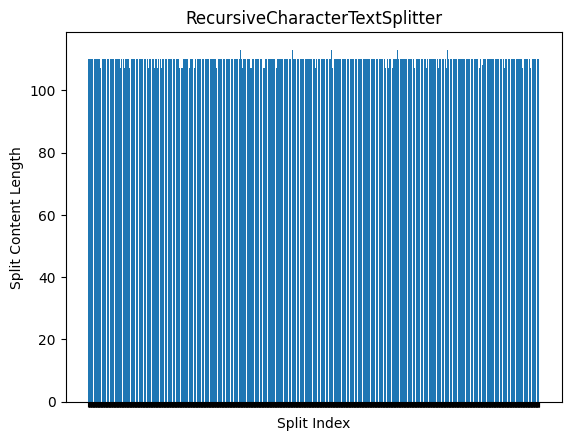

In [6]:
# 시각화
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in patient_splits] # 여기 splits 변경

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Vector DB 저장

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

In [ ]:
# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
patient_vectorstore = Chroma.from_documents(
    documents=patient_splits,
    embedding=embeddings,
    persist_directory="./chroma_patient_db"  # ✅ 여기에 경로 추가!
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
# @title
# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
conditions_vectorstore = Chroma.from_documents(
    documents=conditions_splits, # 43975개 -> 거의 1달러 씀, 1시간 20분 정도 소요 / 5600 -> 10분
    embedding=embeddings,
    persist_directory="./chroma_conditions_db"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
embeddings = UpstageEmbeddings(model="embedding-query")

medications_vectorstore = Chroma.from_documents(
    documents=medications_splits,
    embedding=embeddings,
    persist_directory="./chroma_medications_db"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


RateLimitError: Error code: 429 - {'error': {'message': "You've reached your API request limit. Please wait and try again later. If your use case requires a higher rate limit, you can request an increase at https://support.upstage.ai. Including your intended use case and expected volume will help us process your request faster", 'type': 'too_many_requests', 'param': '', 'code': 'too_many_requests'}}

# Vector DB 로드

In [ ]:
# @title 압축 풀기
!unzip /content/chroma_patient_db.zip -d /content/chroma_patient_db
!unzip /content/chroma_conditions_db.zip -d /content/chroma_conditions_db
!unzip /content/chroma_observation_db.zip -d /content/chroma_observation_db
!unzip /content/chroma_medications.zip -d /content/chroma_medications_db
!unzip /content/chroma_alloergies.zip -d /content/chroma_alloergies_db

Archive:  /content/chroma_medications.zip
   creating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/
  inflating: /content/chroma_medications_db/chroma.sqlite3  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/length.bin  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/index_metadata.pickle  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/data_level0.bin  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/link_lists.bin  
  inflating: /content/chroma_medications_db/df8167d2-d336-451e-a06a-10d3ccffcc6d/header.bin  
Archive:  /content/chroma_alloergies.zip
   creating: /content/chroma_alloergies_db/cf098646-18d3-4908-aa14-f1971b317a14/
  inflating: /content/chroma_alloergies_db/chroma.sqlite3  
  inflating: /content/chroma_alloergies_db/cf098646-18d3-4908-aa14-f1971b317a14/length.bin  
  inflating: /content/chroma_alloergies_db/cf09864

In [5]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

patient_vectorstore = Chroma(
    persist_directory="/content/chroma_patient_db",
    embedding_function=embeddings
)

conditions_vectorstore = Chroma(
    persist_directory="/content/chroma_conditions_db",
    embedding_function=embeddings
)

observation_vectorstore = Chroma(
    persist_directory="/content/chroma_observation_db",
    embedding_function=embeddings
)

medications_vectorstore = Chroma(
    persist_directory="/content/chroma_medications_db",
    embedding_function=embeddings
)

alloergies_vectorstore = Chroma(
    persist_directory="/content/chroma_alloergies_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture

# LLM 생성

In [34]:
# ✅ Dense Retriever 생성
search_k = 5
score = 0.1

patient_retriever = patient_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": search_k},
)

conditions_retriever = conditions_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": search_k},
)

observation_retriever = observation_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": search_k},
)

medications_retriever = medications_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": search_k},
)

alloergies_retriever = alloergies_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": search_k},
)

# ## similarity
# patient_retriever = patient_vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": search_k, "score_threshold": score},
# )

# conditions_retriever = conditions_vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": search_k, "score_threshold": score},
# )

# observation_retriever = observation_vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": search_k, "score_threshold": score},
# )

# medications_retriever = medications_vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": search_k, "score_threshold": score},
# )

# alloergies_retriever = alloergies_vectorstore.as_retriever(
#     search_type="similarity_score_threshold",
#     search_kwargs={"k": search_k, "score_threshold": score},
# )

# ✅ 사용자의 한국어 질문 예시
query = "당뇨병과 아스피린 알러지를 가진 타과 환자가 입원했어. 근데 우리 병원의 과가 달라서 어떤 약을 투약해야 할지 모르겠어. 자세한 투약 정보와 유의사항을 알려줄래?"

# ✅ 검색된 문서 가져오기
patient_docs = patient_retriever.invoke(query)
conditions_docs = conditions_retriever.invoke(query)
observation_docs = observation_retriever.invoke(query)
medications_docs = medications_retriever.invoke(query)
alloergies_docs = alloergies_retriever.invoke(query)

# ✅ 문서 합치기
all_context = "\n".join([
    doc.page_content for doc in (patient_docs + conditions_docs + observation_docs + medications_docs + alloergies_docs)
])

print(all_context)

# ✅ 한국어 system 프롬프트 정의
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 환자 정보에 대한 질문에 친절히 답변하는 한국어 의료 AI 어시스턴트입니다.
            아래 CONTEXT 정보를 참고하여 환자 정보를 자연스럽고 이해하기 쉽게 한국어로 풀어서 설명해 주세요.
            CONTEXT에 포함되지 않은 질병명은 절대 작성하지 마세요. 모르면 "모른다"고 답하세요.
            CONTEXT 정보는 총 5가지로 제공됩니다. 각각은 순서대로 환자 기본 정보, 진단 질병 정보, 바이탈/검사 수치, 약물 투여 기록, 알러지 반응 기록입니다.
            바이탈 정보는 맥박, 혈압 등이 포함됩니다.
            patient_id를 기준으로 같은 환자의 정보를 연결해서 참고하세요.
            각 정보를 의료진이 환자에게 직접 설명하듯 문단 형태로 자연스럽게 이어서 작성해 주세요.
            너무 긴 리스트 형태는 피하고, 중요한 내용은 간결히 요약해 주세요.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# ✅ LLM chain 구성
chain = prompt | llm | StrOutputParser()

# ✅ 최종 chain 호출
response = chain.invoke({"context": all_context, "input": query})

print("\n💬 AI의 답변:")
print(response)


환자 번호 ac1ed279-4fab-1610-e325-9a505b5f0802 환자는,1982-03-17에 태어났고, 성별은 F, 인종은 asian, 민족성은 nonhispanic입니다.
환자 번호 8a742983-bada-f64a-1f75-dfc34f3a60df 환자는,1975-04-21에 태어났고, 성별은 M, 인종은 asian, 민족성은 nonhispanic입니다.
환자 번호 d63977a6-42cc-635e-3822-52aa88338b28 환자는,1984-08-22에 태어났고, 성별은 F, 인종은 asian, 민족성은 nonhispanic입니다.
환자 번호 4fdb9235-e9e3-cc0b-1072-0a70088772a6 환자는,2009-05-16에 태어났고, 성별은 F, 인종은 asian, 민족성은 nonhispanic입니다.
환자 번호 c183c8b5-3352-1bdd-7a3d-4b47f7102397 환자는,2022-10-30에 태어났고, 성별은 M, 인종은 asian, 민족성은 nonhispanic입니다.
PATIENT_ID: df2156e8-3ae4-400f-c4a0-a9f92abc5ce0 환자는 다음과 같은 질병을 진단 받았습니다. 2021-06-19부터 2021-06-20까지 질병 코드 241929008.0의 Acute allergic reaction을(를) 진단 받았습니다. 2021-12-12부터 2021-12-29까지 질병 코드 444814009.0의 Viral sinusitis을(를) 진단 받았습니다. 2022-03-04부터
PATIENT_ID: 7376c718-34e7-8b11-5d7d-2c0d1e54e091 환자는 다음과 같은 질병을 진단 받았습니다. 2021-07-21부터 nan까지 질병 코드 24079001.0의 Atopic dermatitis을(를) 진단 받았습니다. 2022-05-06부터 2022-05-07까지 질병 코드 241929008.0의 Acute allergic reaction을(를) 진단 받았습니다.
PATIENT_I

# 정리
## 프로세스
- 5개의 retriever 별로 5개씩 정보 가져옴
- context는 5 * 5개의 정보를 통합함
- LLM은 context를 토대로 Query에 적절한 답변

## 성능
- 소요 시간: 8 ~ 10초
- 답변 정확도(임의 판단)
  - 정보 조합해서 잘 설명하는 것처럼 보임
  - 실제 환자 ID를 입력했을 때, 일부 누락됨 (데이터가 있음에도)


In [36]:
patient_id = "59ee5bee-ed92-b2e1-c22a-5944801b159a"

# filter로 가져오기
filtered = alloergies_vectorstore._collection.get(
    where={"patient_id": {"$eq": patient_id}},
    include=["documents", "metadatas"]
)

for i, doc in enumerate(filtered["documents"]):
    print(f"\n--- Document {i+1} ---")
    print(doc)
    print(filtered["metadatas"][i])
